## Self supervised large scale generalisatiom

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
s3_prefix = "s3://aegovan-data/selfsupervised_chemprot/predictions_selfsupervised-bert-f1-2022-09-17-23-42-42-470/2022091920/"
s3_output_prefix = "{}_negative_generalisation/".format(s3_prefix.rstrip("/"))
s3_training = "s3://aegovan-data/self-supervised/train.json"



In [3]:
is_download_files= False

In [4]:
label_order = ["False", "True"]
pos_labels = list( filter(lambda x: x , label_order))
label_order_key = lambda x:  label_order.index(x)

label_title_map = {}

In [5]:
local_temp = "../temp"
local_temp_pred_dir = os.path.join( local_temp, "pred_results")
local_temp_wk_dir = os.path.join( local_temp, "wk")

In [6]:
import shutil

def setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir):
    if os.path.exists(local_temp):
        shutil.rmtree(local_temp)
    os.makedirs(local_temp_pred_dir)
    os.makedirs(local_temp_wk_dir)


In [7]:
import boto3
import glob
from multiprocessing.dummy import Pool as ThreadPool
import argparse
import datetime 
import os


def upload_file(localpath, s3path):
        """
Uploads a file to s3
        :param localpath: The local path
        :param s3path: The s3 path in format s3://mybucket/mydir/mysample.txt
        """

        bucket, key = get_bucketname_key(s3path)

        if key.endswith("/"):
            key = "{}{}".format(key, os.path.basename(localpath))
        
        s3 = boto3.client('s3')
        
        s3.upload_file(localpath, bucket, key)

def get_bucketname_key(uripath):
    assert uripath.startswith("s3://")

    path_without_scheme = uripath[5:]
    bucket_end_index = path_without_scheme.find("/")

    bucket_name = path_without_scheme
    key = "/"
    if bucket_end_index > -1:
        bucket_name = path_without_scheme[0:bucket_end_index]
        key = path_without_scheme[bucket_end_index + 1:]

    return bucket_name, key


def download_file(s3path, local_dir):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')
    
    local_file = os.path.join(local_dir, s3path.split("/")[-1])
    

    s3.download_file(bucket, key, local_file)
    
def download_object(s3path):
    bucket, key = get_bucketname_key(s3path)
    
    s3 = boto3.client('s3')    

    s3_response_object = s3.get_object(Bucket=bucket, Key=key)
    object_content = s3_response_object['Body'].read()
    
    return len(object_content)



def list_files(s3path_prefix):
    assert s3path_prefix.startswith("s3://")
    assert s3path_prefix.endswith("/")
    
    bucket, key = get_bucketname_key(s3path_prefix)
    
   
   
    s3 = boto3.resource('s3')
    
    bucket = s3.Bucket(name=bucket)

    return ( (o.bucket_name, o.key) for o in bucket.objects.filter(Prefix=key))





def upload_files(local_dir, s3_prefix, num_threads=20):    
    input_tuples = ( (f,  s3_prefix) for f in glob.glob("{}/*".format(local_dir)))
    
    with ThreadPool(num_threads) as pool:
        pool.starmap(uploadfile, input_tuples)
    


def download_files(s3_prefix, local_dir, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        
        

def download_objects(s3_prefix, num_threads=20):    
    s3_files = ( "s3://{}/{}".format(s3_bucket,s3_key) for s3_bucket, s3_key in list_files(s3_prefix))
    
    with ThreadPool(num_threads) as pool:
        results = pool.map(download_object, s3_files)
        
    return sum(results)/1024
        

def get_directory_size(start_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size

def get_s3file_size(bucket, key):
    s3 = boto3.client('s3')
    response = s3.head_object(Bucket=bucket, Key=key)
    size = response['ContentLength']
    return size
    
def download_files_min_files(s3_prefix, local_dir, min_file_size=310, num_threads=20):    
    input_tuples = ( ("s3://{}/{}".format(s3_bucket,s3_key),  local_dir) for s3_bucket, s3_key in list_files(s3_prefix) if get_s3file_size(s3_bucket, s3_key) > min_file_size )
    
    with ThreadPool(num_threads) as pool:
        results = pool.starmap(download_file, input_tuples)
        


In [8]:
%%time

if is_download_files:
    setup_dir(local_temp,local_temp_pred_dir, local_temp_wk_dir)
    download_files(s3_prefix, local_temp_pred_dir)

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 3.1 µs


In [9]:
!ls -l $local_temp_pred_dir | wc -l

     100


In [10]:
default_threshold =  0.99
threshold_config =  {l: { "confidence":default_threshold}  for l in label_order}


In [11]:
threshold_config

{'False': {'confidence': 0.99}, 'True': {'confidence': 0.99}}

In [12]:
def load_df_from_files(local_temp_pred_dir):
   
    list_df = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)
        list_df.append(df)
    return pd.concat(list_df)


In [13]:
def get_summary_df(local_temp_pred_dir, use_std=False):
    list_df_high_quality = []
    list_df_low_quality = []
    list_df_summary = []
    for f in os.listdir(local_temp_pred_dir):
        df = pd.read_json(os.path.join(local_temp_pred_dir, f), orient="records" )
        df["prediction"]=df["prediction"].astype(str)

        
        list_df_summary.append(df[["prediction", "confidence", "confidence_std", "abstract_id"]])

        # Filter below threshold items
        high_quality_frames_per_interaction = []
        low_quality_frames_per_interaction = []


        for k,t in threshold_config.items():
            conf_median = t["confidence"]
            conf_std_median = 1.0
            
            # HQ filter query
            high_qry = "prediction == '{}' and confidence >= {} and confidence_std <= {}" .format(k, conf_median, conf_std_median)
            if not use_std:
                high_qry = "prediction == '{}' and confidence >= {} " .format(k, conf_median)
            df_sub = df.query(high_qry)
            sample = min(1000, len(df_sub) )
            high_quality_frames_per_interaction.append(df_sub.sample(n=sample))


            # Low quality filter query
            conf_min = 0.8
            conf_std_min = 0.0
            low_qry = "prediction == '{}' and confidence < {} and confidence_std > {}" .format(k, conf_min, conf_std_min)
            if not use_std:
                low_qry = "prediction == '{}' and confidence < {} " .format(k, conf_min)
            df_low = df.query(low_qry)
            sample=min(1000, len(df_low) )
            low_quality_frames_per_interaction.append(df_low.sort_values(by=["prediction", "confidence_std"]).head(n=sample))
           

        high_quality_df = pd.concat(high_quality_frames_per_interaction)
        low_quality_df = pd.concat(low_quality_frames_per_interaction)


        list_df_high_quality.append(high_quality_df)
        list_df_low_quality.append(low_quality_df)


    
    return pd.concat(list_df_high_quality), pd.concat(list_df_summary), pd.concat(list_df_low_quality)



In [14]:


def is_in_training_pubmed(df, training_df):
    return df["abstract_id"].isin(training_df["abstract_id"])

In [15]:
download_file(s3_training, local_temp_wk_dir)
training_data_file = os.path.join(local_temp_wk_dir, s3_training.split("/")[-1])
data_training_full_df = pd.read_json(training_data_file)

In [16]:
%%time 


df_high_quality_threshold, df_summary, df_low_quality_threshold = get_summary_df (local_temp_pred_dir)
df_high_quality_threshold[ "RecordInTrainingData"] = is_in_training_pubmed( df_high_quality_threshold, data_training_full_df)
df_summary["RecordInTrainingData"] = is_in_training_pubmed( df_summary, data_training_full_df)
df_low_quality_threshold[ "RecordInTrainingData"]= is_in_training_pubmed( df_low_quality_threshold, data_training_full_df)

CPU times: user 21 s, sys: 1.12 s, total: 22.1 s
Wall time: 23.1 s


In [17]:
df_summary.dtypes

prediction               object
confidence              float64
confidence_std          float64
abstract_id               int64
RecordInTrainingData       bool
dtype: object

In [18]:
df_summary.groupby("prediction")["confidence"].describe()

,count,mean,std,min,25%,50%,75%,max
prediction,,,,,,,,
False,2019270.0,0.990737,0.045619,0.500013,0.998954,0.999207,0.999253,0.999648
True,222440.0,0.932311,0.116868,0.500005,0.932357,0.990719,0.997000,0.998745


In [19]:
import matplotlib.gridspec as gridspec

import numpy as np

def box_plot_prediction_confidence(df, df_high_quality, subplot_spec, title_prefix="", set_title=True):
    
    df = df[~df.RecordInTrainingData].copy()
    df_high_quality = df_high_quality[~df_high_quality.RecordInTrainingData].copy()
    
    
    interaction_types = label_order
    
    num_plots = len(interaction_types)
    gs = gridspec.GridSpecFromSubplotSpec(1, len(label_order), subplot_spec=subplot_spec)
    
    for i, interaction in enumerate(interaction_types):
        df_interaction = df.query(f"prediction == '{interaction}'")
        df_interaction_high_quality = df_high_quality.query(f"prediction == '{interaction}'")
        
        if len(df_interaction) == 0: continue
        
        ax = fig.add_subplot(gs[0, i])
    
    
        # Rename columns
        new_column_names = {"confidence":"c", 
                           "confidence_std" : "v"
                            }
        df_interaction = df_interaction.rename(columns = new_column_names)
        df_interaction_high_quality=df_interaction_high_quality.rename(columns = new_column_names)
        
        
        # Style and formatting..
        
        if set_title:
            ax.set_title("{}{}\nT={} (HQ={}%)".format( title_prefix,
                                               label_title_map.get(interaction, interaction).title(),
                                               len(df_interaction),
                                               round(100 * len(df_interaction_high_quality)/len(df_interaction),2)                
                                              )
                        )
        ax.set_ylim(0,1)
        
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
        
        ax.spines['bottom'].set_color('grey')
        ax.spines['top'].set_color('grey') 
        ax.spines['right'].set_color('grey')
        ax.spines['left'].set_color('grey')
        
        
        # Plot violin plot        
        ax.violinplot(df_interaction[["c", "v" ]],  showmeans=True )
        if len(df_interaction_high_quality) > 0:
            ax.violinplot(df_interaction_high_quality[["c", "v" ]],  showmeans=True )
        
        
        x_labels = ['C', 'V']
        
        ax.xaxis.set_tick_params(direction='out')
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.arange(1, len(x_labels) + 1))
        ax.set_xticklabels(x_labels)
        ax.set_xlim(0.25, len(x_labels) + 0.75)
        
        
       



        


In [20]:
df_high_quality_threshold.shape, df_summary.shape

((188134, 9), (2241710, 5))

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


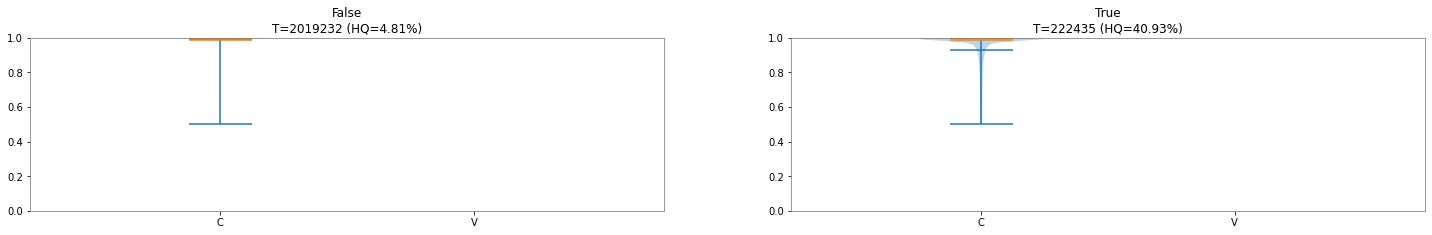

In [21]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_high_quality_threshold, gs[0])

plt.savefig("largescaleprediction_distribution.pdf", bbox_inches="tight")

In [22]:
df_summary["confidence"].describe()

count    2.241710e+06
mean     9.849394e-01
std      5.945568e-02
min      5.000048e-01
25%      9.984179e-01
50%      9.991896e-01
75%      9.992476e-01
max      9.996483e-01
Name: confidence, dtype: float64

In [23]:
df_low_quality_threshold["prediction"].value_counts()

False    31142
True     28902
Name: prediction, dtype: int64

/Users/aparnaelangovan/PycharmProjects/venv/large-scale-ptm-ppi/lib/python3.7/site-packages/numpy/linalg/linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


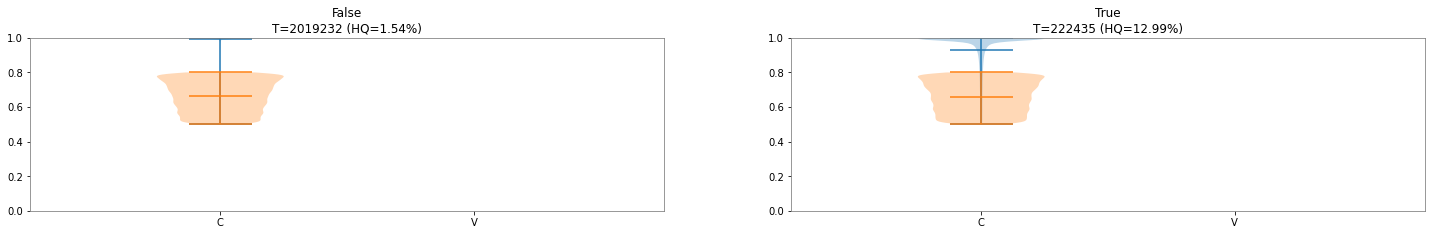

In [24]:
fig = plt.figure(figsize=(25 , 7))
gs = fig.add_gridspec(nrows=2)

box_plot_prediction_confidence(df_summary, df_low_quality_threshold, gs[0])



In [25]:
df_summary.shape

(2241710, 5)

In [26]:
df_summary[["confidence","prediction"]].groupby("prediction").describe().T

prediction               False           True
confidence count  2.019270e+06  222440.000000
           mean   9.907368e-01       0.932311
           std    4.561930e-02       0.116868
           min    5.000131e-01       0.500005
           25%    9.989537e-01       0.932357
           50%    9.992068e-01       0.990719
           75%    9.992532e-01       0.997000
           max    9.996483e-01       0.998745

In [27]:
%%time

def prepare_predictions_summary(df_full, df_high_quality_threshold):
    
    
    df_full = df_full[~df_full.RecordInTrainingData].copy()
    
    df_high_quality_threshold = df_high_quality_threshold[~df_high_quality_threshold.RecordInTrainingData].copy()


        
    
    summary_df = pd.DataFrame(df_full
                  .groupby([ "prediction"]).size()).rename(columns={0: "all_count"})

    

    thresh_df = pd.DataFrame(df_high_quality_threshold\
              .groupby('prediction').size())\
              .rename(columns={0: "thresh_count"})
    
    
    
    
    dfs = [summary_df,  thresh_df]
    result_df = pd.DataFrame()
    
    for df in dfs:
        result_df = result_df.merge(df, left_index=True,  right_index=True, how="outer")
        
        
    for col in result_df.columns:
        result_df.loc["Total",col] = result_df[col].sum()
        
    result_df = result_df.fillna(0)
        
    result_df = result_df.astype(int)
    return result_df


latex_df_results = prepare_predictions_summary(df_summary, df_high_quality_threshold)

print(latex_df_results.to_latex( index=True))

latex_df_results

\begin{tabular}{lrr}
\toprule
{} &  all\_count &  thresh\_count \\
prediction &            &               \\
\midrule
False      &    2019232 &         97078 \\
True       &     222435 &         91049 \\
Total      &    2241667 &        188127 \\
\bottomrule
\end{tabular}

CPU times: user 204 ms, sys: 4.84 ms, total: 209 ms
Wall time: 213 ms


,all_count,thresh_count
prediction,,
False,2019232,97078
True,222435,91049
Total,2241667,188127


In [28]:
df_high_quality_threshold.groupby(["prediction"]).size()

prediction
False    97081
True     91053
dtype: int64

In [29]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

plt.rcParams.update({'font.size': 12})

In [30]:

local_file_high_q_sample = os.path.join(local_temp, "highquality_sample.json")
local_file_low_q_sample = os.path.join(local_temp, "lowquality_sample.json")

df_high_quality_threshold.to_json(local_file_high_q_sample,  orient='records')
df_low_quality_threshold.to_json(local_file_low_q_sample,   orient='records')




In [31]:
upload_file( local_file_high_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))
upload_file( local_file_low_q_sample, "{}/".format( s3_output_prefix.rstrip("/")))



In [32]:
from utils.ppi_multiclass_comparer import PpiMulticlassComparer
from utils.similarity_comparer import SimilarityComparer
import pandas as pd
import tempfile
import transformers

def get_sim_scores(ref_file_or_df, target_file_or_df, n_gram, additional_target_cols):
    marker_ref_file = ref_file_or_df
    marker_target_file = target_file_or_df

    
    if isinstance(ref_file_or_df, str):
        df_ref_marker = pd.read_json(marker_ref_file)
        df_target_marker =  pd.read_json(marker_target_file)
    else:
        df_ref_marker = marker_ref_file
        df_target_marker = marker_target_file
        
    t = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
    
    comparer =  SimilarityComparer(n_gram=n_gram, max_features=None, stop_words=None, analyzer=lambda x: t.convert_ids_to_tokens(t([x], add_special_tokens=False)["input_ids"][0])[:512])
    comparison_result = comparer(df_ref_marker["abstract"].tolist(), df_target_marker["abstract"].tolist())
    
    sim_score = comparison_result[0]
    
    df_target_marker["sim_score"]  = comparison_result[0]
    return df_target_marker
    
def plot_sim_scores(df, ax, interaction, title_prefix ):
    
    for i, interaction_type in enumerate(interaction): 
        df_interaction = df.query(f"interaction_type == '{interaction_type}'")
        
        if len(df_interaction) ==0: continue
            
        ax[i].set_ylim(0,1)
        
        ax[i].set_title(f"{title_prefix} {interaction_type}")

        ax[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

        ax[i].spines['bottom'].set_color('grey')
        ax[i].spines['top'].set_color('grey') 
        ax[i].spines['right'].set_color('grey')
        ax[i].spines['left'].set_color('grey')
        
        

        ax[i].violinplot(df_interaction["best_score"],  showmeans=True )

In [33]:
df_high_quality_threshold.shape

(188134, 9)

In [34]:
df_sim_score_high = get_sim_scores(data_training_full_df, df_high_quality_threshold, n_gram=1, additional_target_cols=list(df_high_quality_threshold.columns))

df_sim_score_high.head()


Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors


,abstract_id,abstract,false,true,prediction,confidence,confidence_std,raw_confidence,RecordInTrainingData,sim_score
0,20791654,Liver scan characteristics and liver function ...,0.999275,0.000725,False,0.999275,NaN,[0.999274671077728],False,0.479161
4,20791862,An abrupt method of terminating prescriptions ...,0.999256,0.000744,False,0.999256,NaN,[0.9992560744285581],False,0.520285
12,20791877,Subtyping of hepatitis B antigen (HBA) in bloo...,0.999327,0.000673,False,0.999327,NaN,[0.9993270635604851],False,0.519775
6,20791871,Immunological studies were performed on 24 chi...,0.998904,0.001095,False,0.998904,NaN,[0.9989044666290281],False,0.532423
5,20791870,All deaths from road accidents in certain area...,0.999197,0.000803,False,0.999197,NaN,[0.9991967082023621],False,0.550104


<AxesSubplot:>

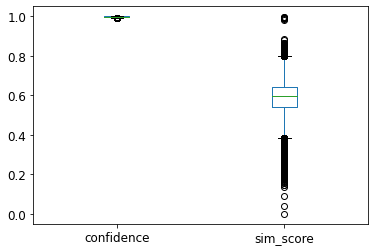

In [35]:
df_sim_score_high[["confidence","sim_score"]].plot.box()

Token indices sequence length is longer than the specified maximum sequence length for this model (728 > 512). Running this sequence through the model will result in indexing errors


<AxesSubplot:>

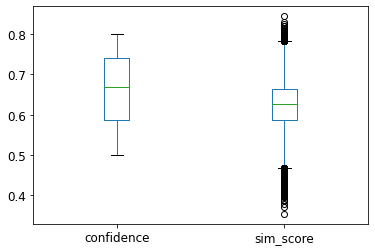

In [36]:
df_sim_score_low = get_sim_scores(data_training_full_df, df_low_quality_threshold, n_gram=1, additional_target_cols=list(df_low_quality_threshold.columns))
df_sim_score_low[["confidence","sim_score"]].plot.box()

In [37]:
def plot_box_sim_scores_confidence(df_high, df_low):
    p_unique = sorted(list(df_high["prediction"].unique()))
    
    _, axes = plt.subplots(1, len(p_unique), figsize=(30 ,8))
    
    for i, l in enumerate(p_unique):
        dh = df_high.query(f"prediction == '{l}'")
        dl = df_low.query(f"prediction == '{l}'")
        
        dl = dl[["confidence", "sim_score"]]
        dh = dh[["confidence", "sim_score"]]                   
                    
        
        data = dh.values.T.tolist()
        data.extend(dl.values.T.tolist())
      
        ax=axes[i]
        ax.boxplot(data, showmeans=True)
        ax.set_title(l)
        ax.set_xticklabels(["GHC","GHS", "GLC", "GLS"])


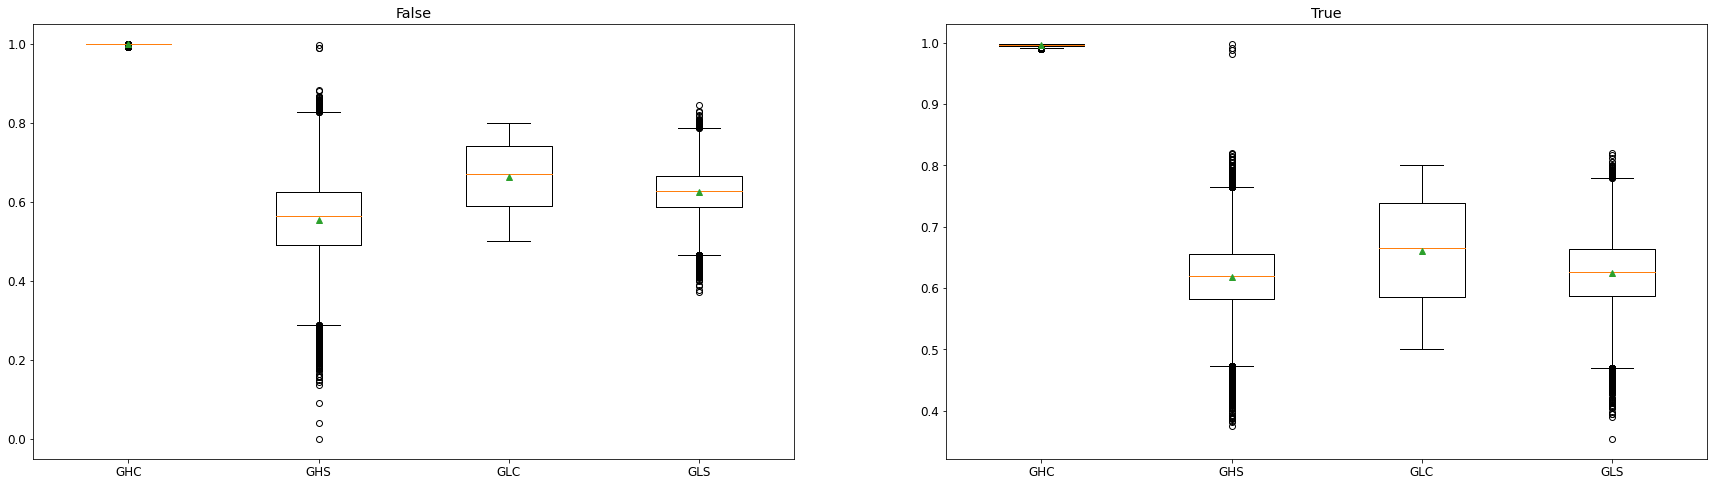

In [38]:
plot_box_sim_scores_confidence(df_sim_score_high, df_sim_score_low)

In [39]:
df_sim_score_high[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False         97081.0  0.998877  0.001126  0.990000  0.999075  0.999216   
True          91053.0  0.996163  0.002101  0.990002  0.995105  0.996950   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.999258  0.999640   97081.0  0.553315  0.098807  0.000000   
True        0.997761  0.998738   91053.0  0.617890  0.054327  0.375173   

                                                    
                 25%       50%       75%       max  
prediction                                          
False       0.489807  0.564819  0.624845  0.996479  
True        0.582275  0.619437  0.655098  0.998004

In [40]:
df_sim_score_low[["confidence", "sim_score","prediction"]].groupby(["prediction"]).describe()

confidence                                                    \
                count      mean       std       min       25%       50%   
prediction                                                                
False         31142.0  0.663448  0.087475  0.500013  0.589295  0.669999   
True          28902.0  0.660325  0.087674  0.500005  0.585394  0.665283   

                               sim_score                                \
                 75%       max     count      mean       std       min   
prediction                                                               
False       0.741396  0.799999   31142.0  0.625184  0.059389  0.371043   
True        0.738018  0.799998   28902.0  0.624044  0.057897  0.353648   

                                                    
                 25%       50%       75%       max  
prediction                                          
False       0.586114  0.627106  0.666322  0.844576  
True        0.586253  0.625890  0.663748  0.820471

In [41]:
df_sim_score_high.query("sim_score < 0.65 and prediction == 'True'").sample(n=1).iloc[0]["abstract"]

'Due to their easy accessibility, proteins outside of the plasma membrane represent an ideal but untapped resource for potential drug targets or disease biomarkers. They constitute the major biochemical class of current therapeutic targets and clinical biomarkers. Recent advances in proteomic technologies have fueled interest in analysis of extracellular proteins such as membrane proteins, cell surface proteins, and secreted proteins. However, unlike the gene expression analyses from a variety of tissues and cells using genomic technologies, quantitative proteomic analysis of proteins from various biological sources is challenging due to the high complexity of different proteomes and the lack of robust and consistent methods for analyses of different tissue sources, especially for specific enrichment of extracellular proteins. Since most extracellular proteins are modified by oligosaccharides, the population of glycoproteins therefore represents the majority of extracellular proteomes.

In [42]:
df_sim_score_low.query("sim_score < 0.65 and prediction == 'True'").sample(n=1).iloc[0]["abstract"]

"ABSTRACT Two isolates of the barley net blotch pathogen (Pyrenophora teres f. teres), one possessing high virulence (0-1) and the other possessing low virulence (15A) on the barley cultivar Harbin, were crossed and the progeny of the mating were isolated. Conidia from cultures of the parent and progeny isolates were used as inoculum to determine the inheritance of virulence in the pathogen. Of the 82 progeny tested, 42 exhibited high virulence and 40 exhibited low virulence on 'Harbin' barley. The data support a model in which a single, major gene controls virulence in P. teres f. teres on this barley cultivar (1:1 ratio; chi(2) = 0.05, P = 0.83). Preparations of DNA were made from parental and progeny isolates, and the DNA was subjected to the random amplified polymorphic DNA (RAPD) technique in a search for molecular genetic markers associated with the virulence phenotype. Five RAPD markers were obtained that were associated in coupling with low virulence. The data indicate that the